In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import os
import time
import random

def videos_to_frames(input_folder, output_folder, min_interval=1, max_interval=2):
    """Function to extract frames with detected faces from video files in the input folder
    and save them as separate frames in the output folder with subfolders for each video.

    Args:
        input_folder: Input folder containing video files.
        output_folder: Output folder to save the frames.
        min_interval: Minimum interval (in seconds) between frames.
        max_interval: Maximum interval (in seconds) between frames.
    Returns:
        None
    """
    # Load pre-trained face detector (Haar Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for video_file in os.listdir(input_folder):
        # Construct the full path to the video file
        input_loc = os.path.join(input_folder, video_file)

        # Skip if it's not a file or not a video (simple filter for mp4, avi, etc.)
        if not os.path.isfile(input_loc) or not video_file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue

        # Create a subdirectory for frames of this specific video
        video_name = os.path.splitext(video_file)[0]
        video_output_folder = os.path.join(output_folder, video_name)
        if not os.path.exists(video_output_folder):
            os.makedirs(video_output_folder)

        # Start capturing the video
        cap = cv2.VideoCapture(input_loc)
        if not cap.isOpened():
            print(f"Error opening video file: {input_loc}")
            continue

        fps = int(cap.get(cv2.CAP_PROP_FPS))  # Get the frame rate of the video
        video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Converting video '{video_file}' with {video_length} frames at {fps} FPS...\n")

        count = 0
        frame_number = 0
        while cap.isOpened():
            # Calculate a random interval in seconds and convert it to frames
            interval = random.randint(min_interval, max_interval)
            skip_frames = interval * fps // 2  # Reduce skip to capture more frames

            # Set the frame position to skip frames
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            if not ret:
                break

            # Convert the frame to grayscale for face detection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=3, minSize=(30, 30))

            if len(faces) > 0:
                # Save the frame if a face is detected
                frame_filename = os.path.join(video_output_folder, f"{count:05d}.jpg")
                cv2.imwrite(frame_filename, frame)
                count += 1

            # Move to the next frame position based on the interval
            frame_number += skip_frames

        # Release the video capture
        cap.release()
        print(f"Done extracting frames from '{video_file}'. {count} frames with faces extracted.\n")

if __name__ == "__main__":
    input_folder = '/content/drive/MyDrive/Vid_to_Frames/Video'
    output_folder = '/content/drive/MyDrive/Vid_to_Frames/Frame_extraction'
    videos_to_frames(input_folder, output_folder)
=

In [ ]:
!nvidia-smi

Thu Nov 28 11:01:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%cd /content/drive/MyDrive/PDS/People_Counting
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

## Fine-tune YOLO11 on custom dataset

In [ ]:
!mkdir /content/drive/MyDrive/PDS/People_Counting
%cd /content/drive/MyDrive/PDS/People_Counting

from google.colab import userdata
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="I1hO79CqDrKg9qJOiHOd")
project = rf.workspace("cqupt-b8vkv").project("people-count-8vvwf")
version = project.version(1)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/drive/MyDrive/PDS/People_Counting’: File exists
/content/drive/MyDrive/PDS/People_Counting
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to people-count-1 in yolov11:: 100%|██████████| 980/980 [00:07<00:00, 134.60it/s]


## Custom Training

In [ ]:
%cd /content/drive/MyDrive/PDS/People_Counting

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content/drive/MyDrive/PDS/People_Counting
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/PDS/People_Counting/people-count-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls /content/drive/MyDrive/PDS/People_Counting/runs/detect/train

args.yaml					    P_curve.png       train_batch2520.jpg
confusion_matrix_normalized.png			    PR_curve.png      train_batch2521.jpg
confusion_matrix.png				    R_curve.png       train_batch2522.jpg
events.out.tfevents.1732792095.910e2e4e5fc9.4106.0  results.csv       train_batch2.jpg
F1_curve.png					    results.png       val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					    train_batch1.jpg  weights


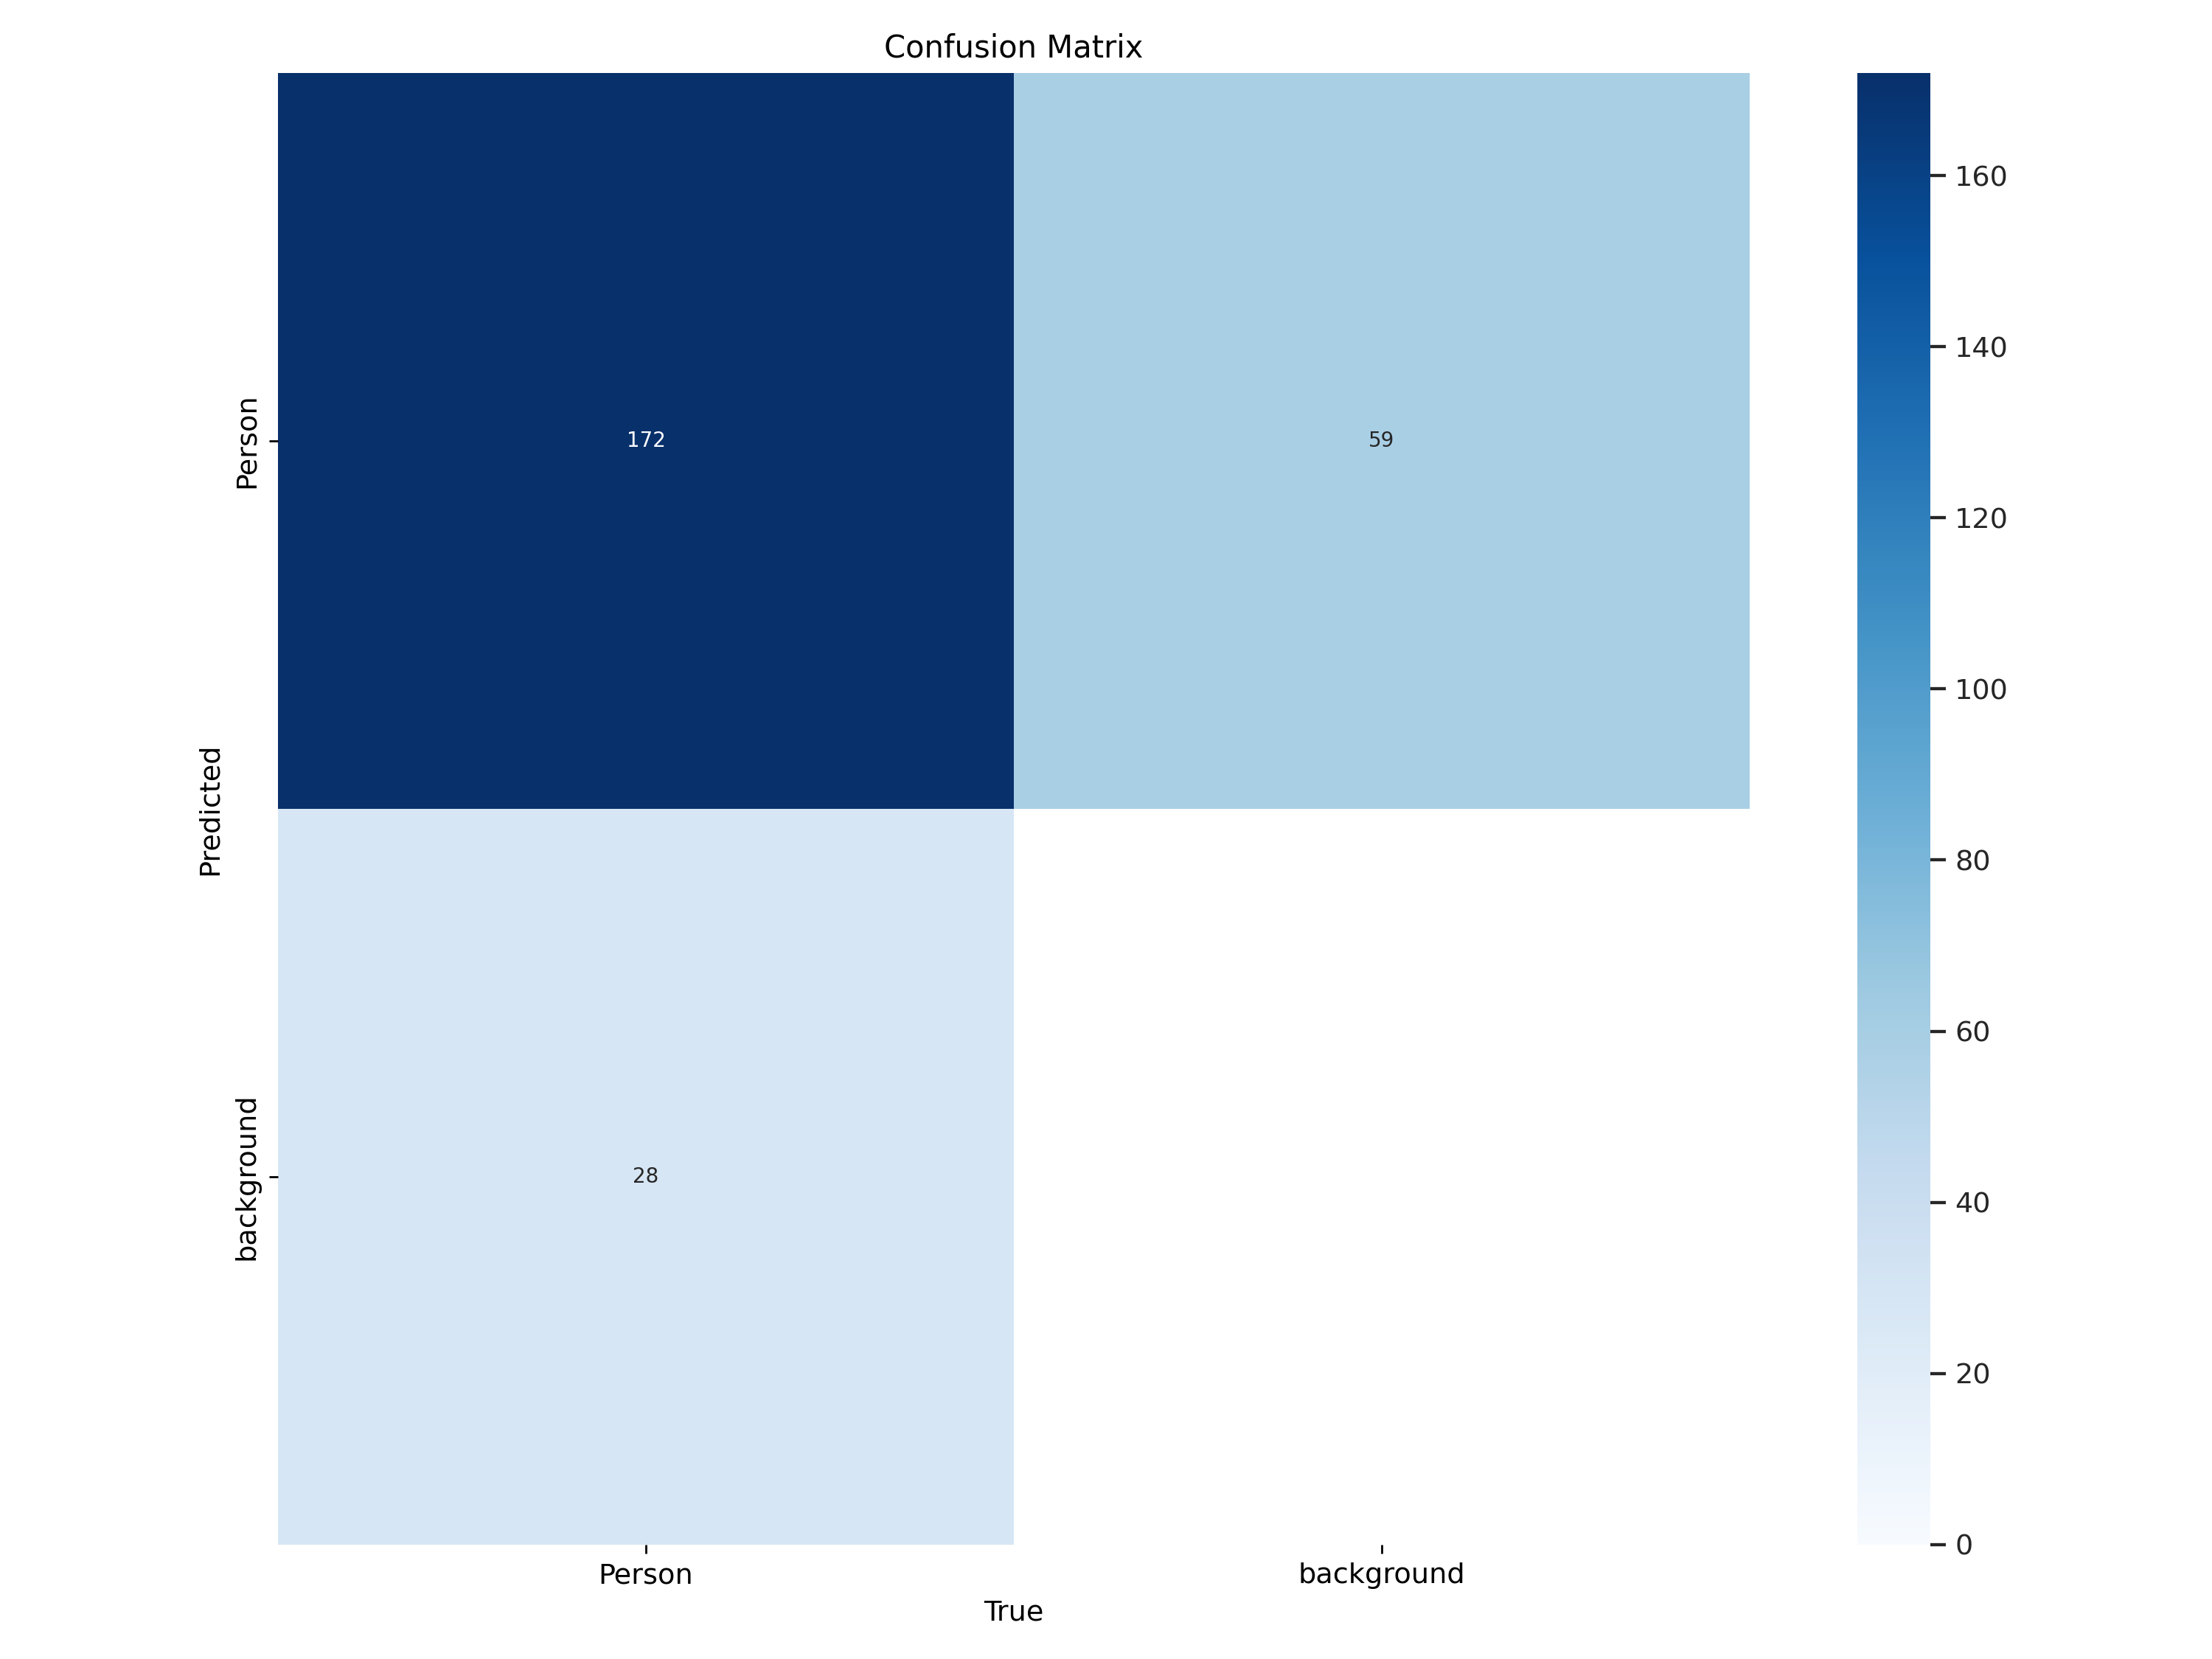

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/confusion_matrix.png', width=600)

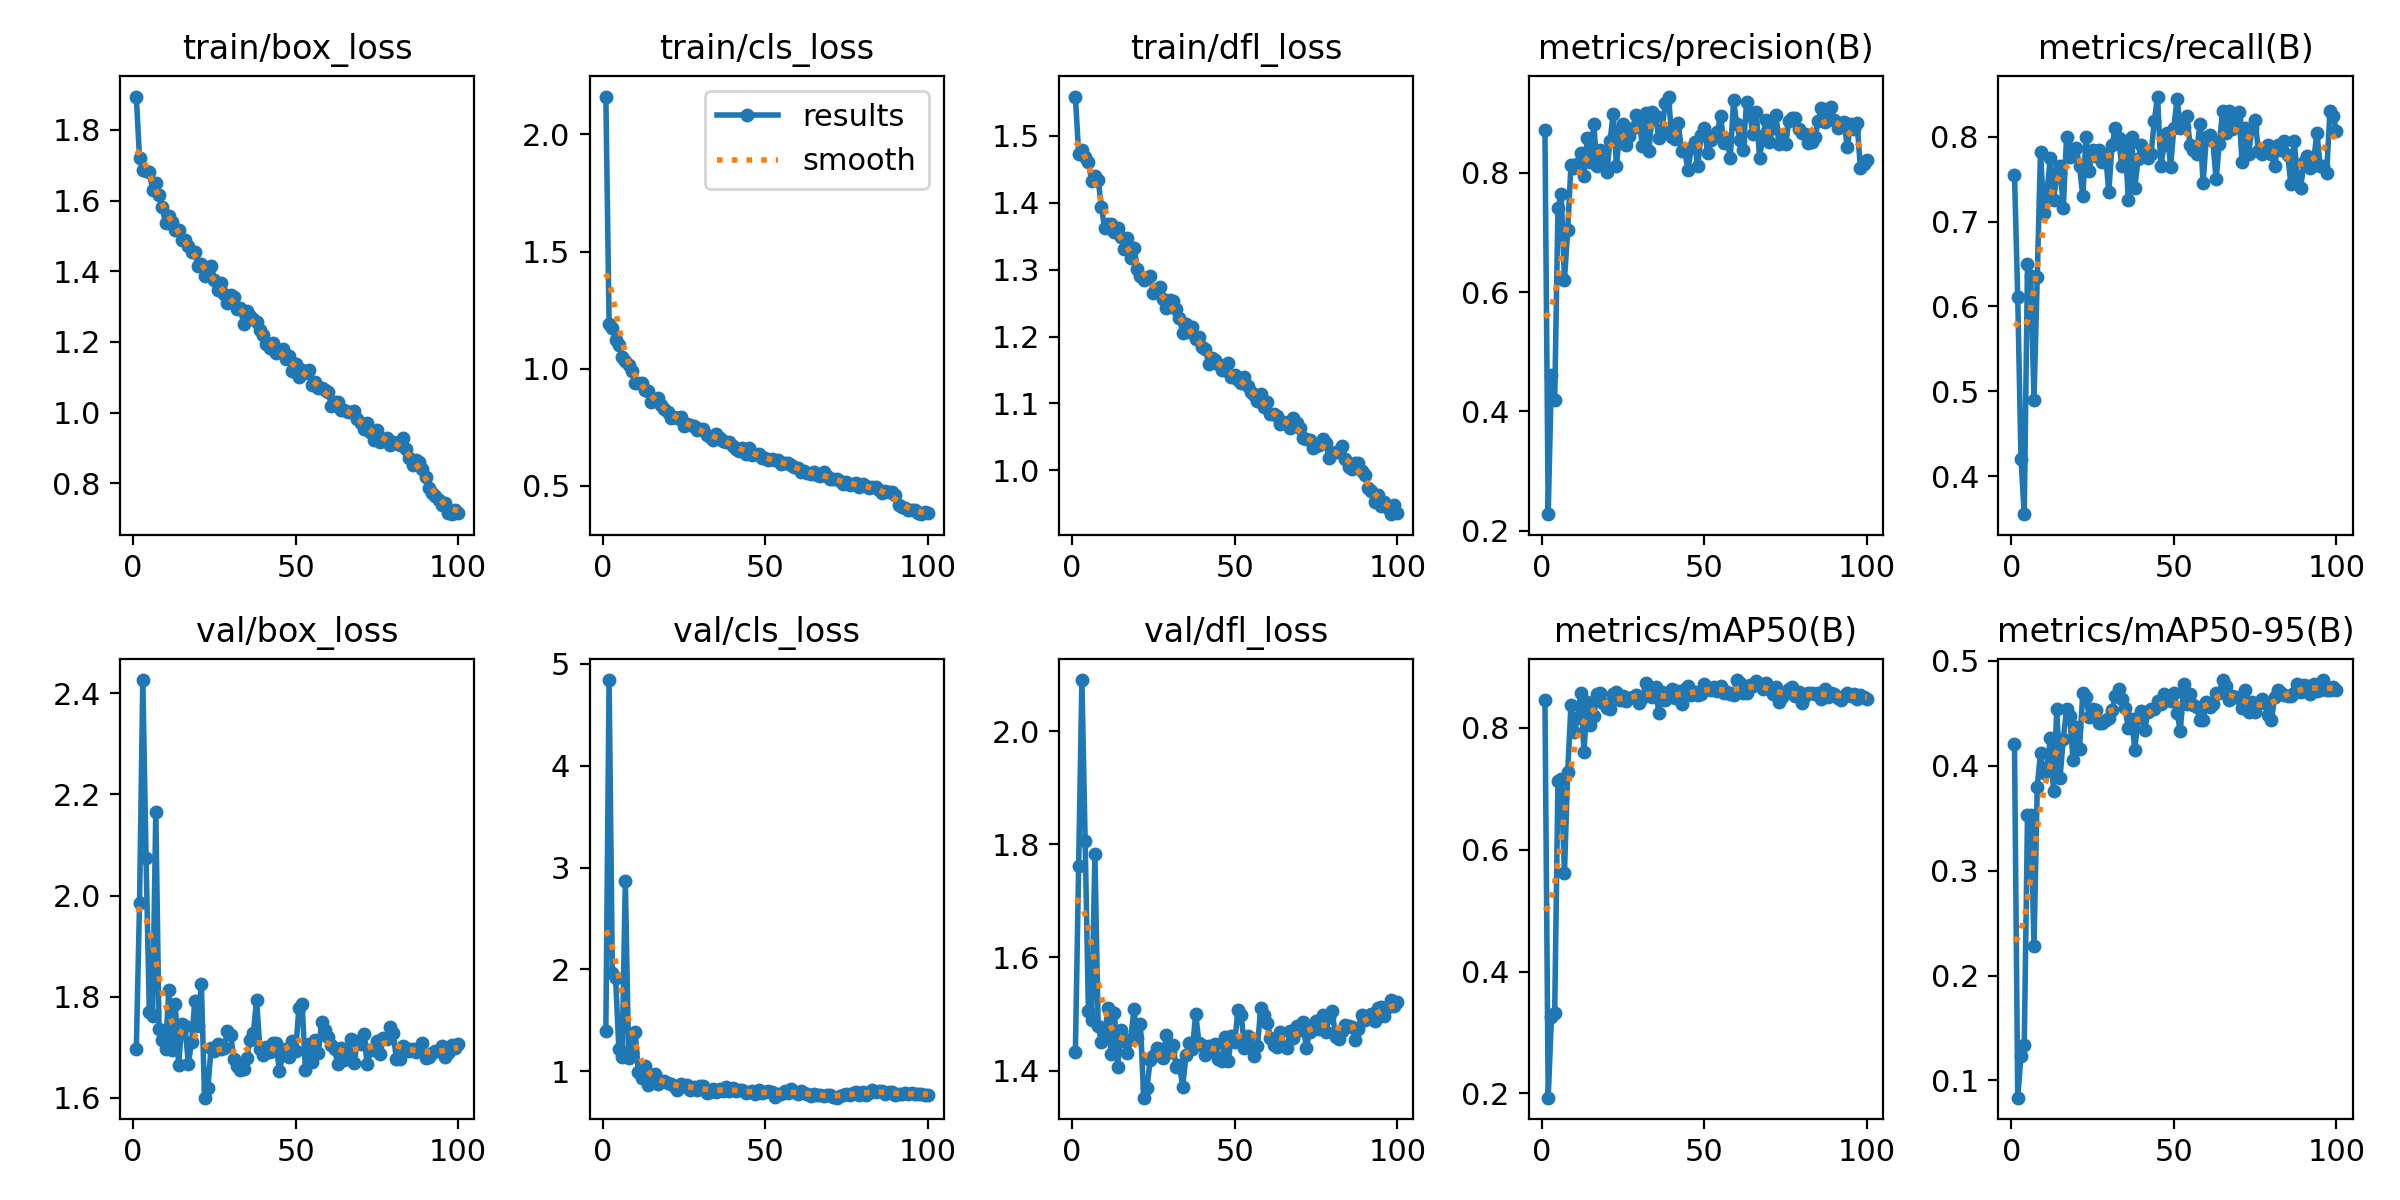

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/results.png', width=600)

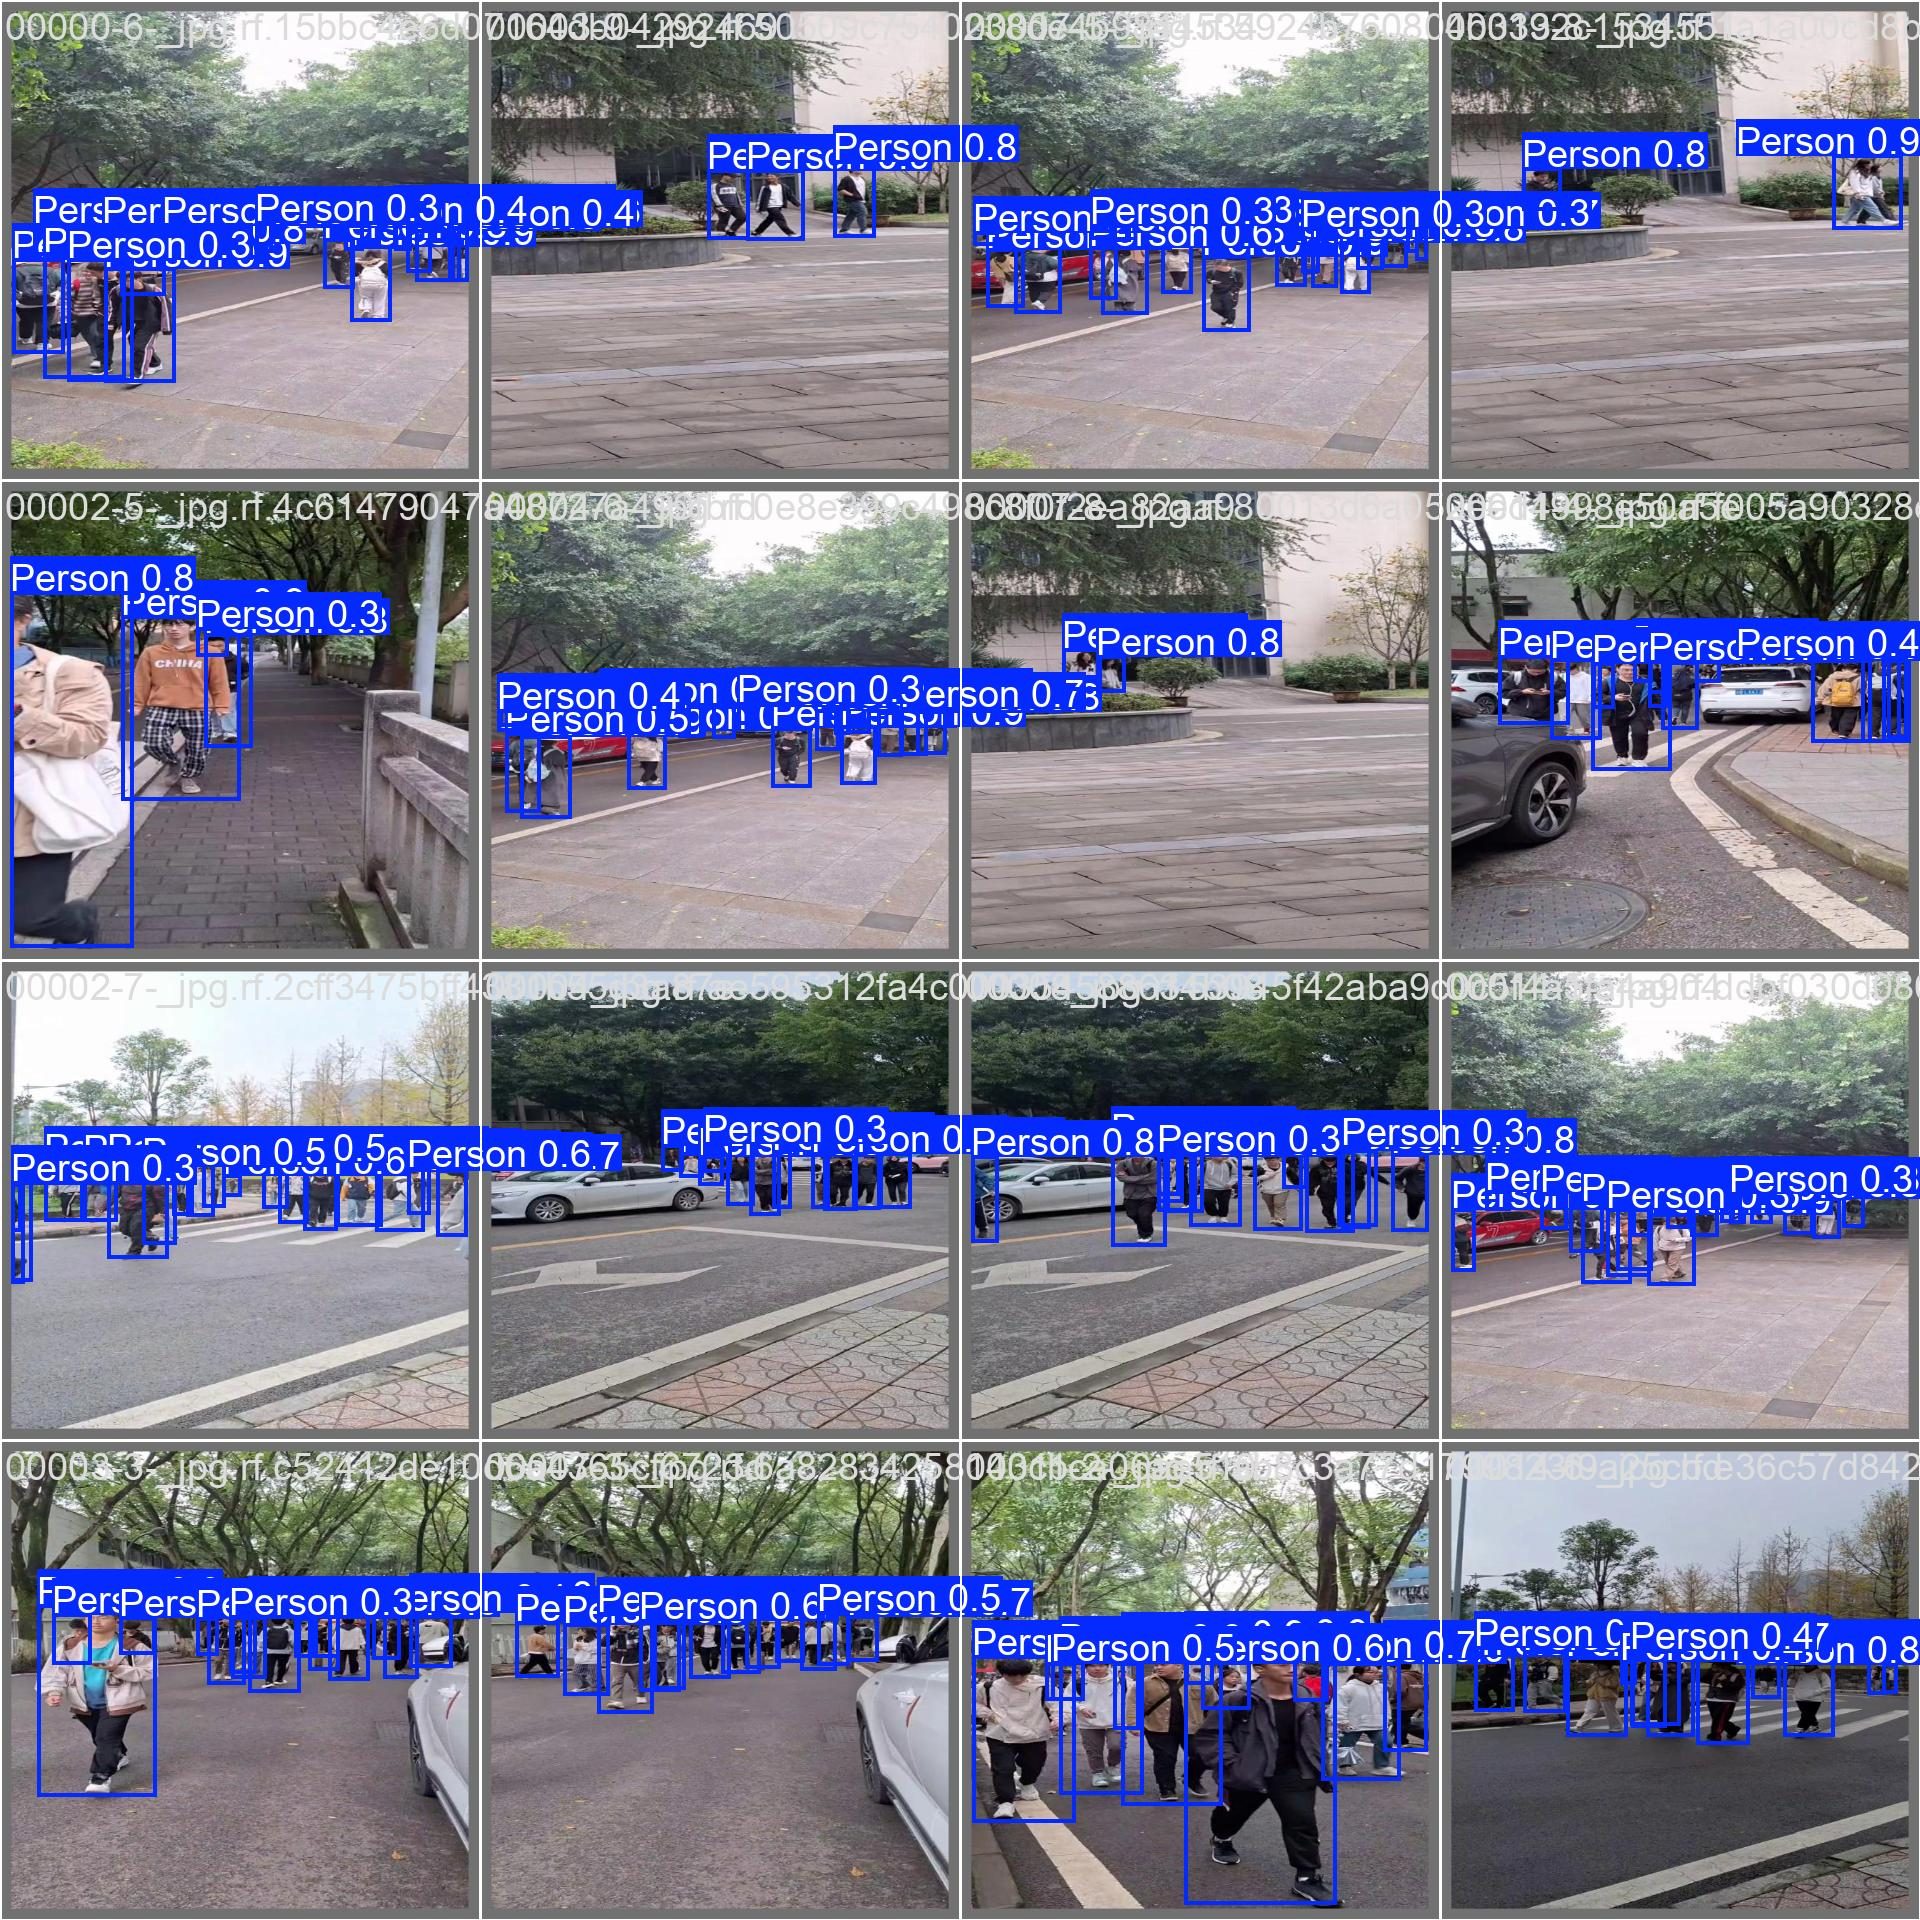

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/drive/MyDrive/PDS/People_Counting/people-count-1/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.11it/s]
                   all         19        200      0.866       0.83       0.87      0.481
Speed: 6.2ms preprocess, 20.9ms inference, 0.0ms loss, 36.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/19 /content/drive/MyDrive/PDS/People_Counting/people-count-1/test/images/00000-7-_jpg.rf.d3f1df49c7efb06c3314dc96f46f2b27.jpg: 640x640 14 Persons, 15.7ms
image 2/19 /content/drive/MyDrive/PDS/People_Counting/people-count-1/test/images/00000-8-_jpg.rf.b3ad78090dcdd59bae1747637b179b9a.jpg: 640x640 9 Persons, 15.6ms
image 3/19 /content/drive/MyDrive/PDS/People_Counting/people-count-1/test/images/00002-6-_jpg.rf.2ca46e6cdfef5eb22041d6bebe46f126.jpg: 640x640 22 Persons, 15.5ms
image 4/19 /content/drive/MyDrive/PDS/People_Counting/people-count-1/test/images/00004-3-_jpg.rf.bf56041b2680fb9f2093ad68800a0d29.jpg: 640x640 10 Persons, 15.5ms
image 5/19 /content/drive/MyDrive/PDS/People_Counting/people-count-1/test/images/00004-9-_jpg.rf.fd4f46c386651a98976b6edb5862f60b.jpg: 640x640 5 Persons, 15.5ms
image 6/19 /content/drive

**NOTE:** Let's take a look at few results.

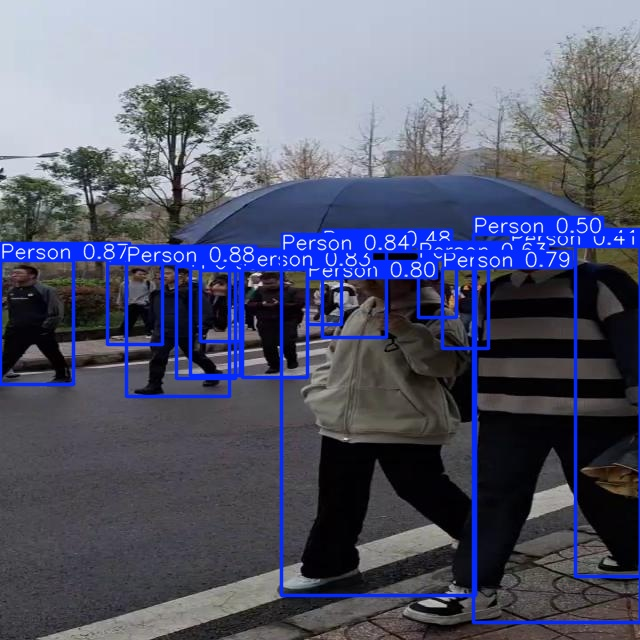

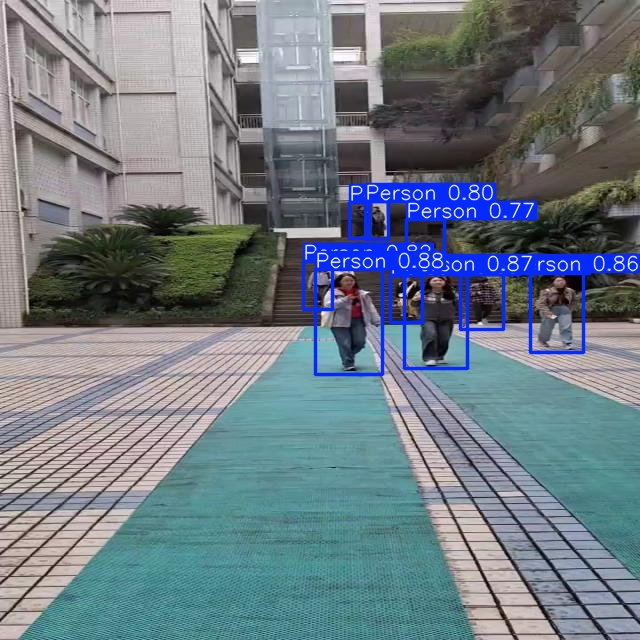

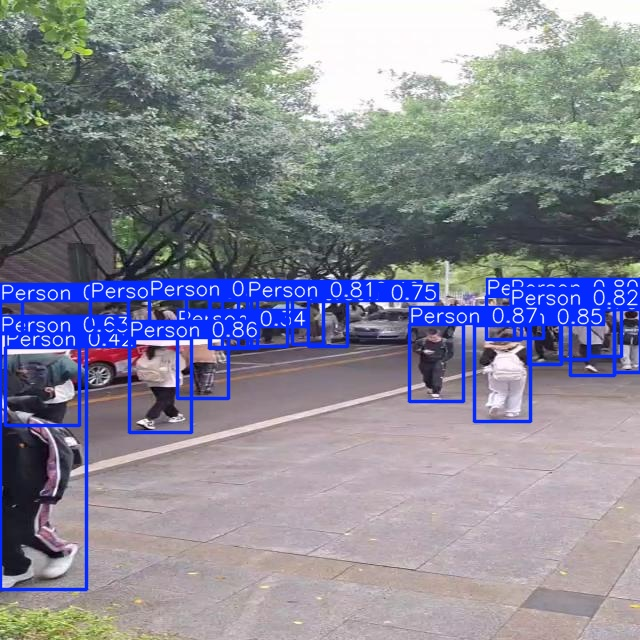

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/drive/MyDrive/PDS/People_Counting/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
from ultralytics import YOLO
import os
import shutil

# Paths to the image and trained model
image_path = '/content/drive/MyDrive/WhatsApp Image 2022-10-20 at 4.10.21 PM.jpeg'  # Replace with your image file path
model_path = '/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt'  # Replace with your trained YOLOv11 model

# Load the custom-trained YOLOv11 model
model = YOLO(model_path)

# Perform inference on the image
results = model(image_path)

# Display results for the first image in the results
if results:  # Check if results are not empty
    results[0].plot()  # Use .plot() to visualize results with bounding boxes and labels

    # Save the image with bounding boxes drawn
    saved_image_path = results[0].save()  # This now returns the full path to the saved image
    print(f"Results saved in: {saved_image_path}")

    # Define the custom output path
    output_path = '/content/people_detected_custom_yolov11.jpg'

    # Check if the file exists before moving
    if os.path.exists(saved_image_path):
        shutil.move(saved_image_path, output_path)
        print(f"Saved result at {output_path}")
    else:
        print(f"Error: File not found at {saved_image_path}")

    # Extract bounding box data (assuming single class 'person')
    # Bounding boxes: [x_center, y_center, width, height, confidence, class]
    detections = results[0].boxes.data  # Extract the bounding boxes from the first image's results
    person_detections = detections[detections[:, -1] == 0]  # Filter by class index 0 (person)

    # Count and print the number of detected people
    num_people = len(person_detections)
    print(f'Number of people detected: {num_people}')
else:
    print("No results returned.")



image 1/1 /content/drive/MyDrive/WhatsApp Image 2022-10-20 at 4.10.21 PM.jpeg: 384x640 26 Persons, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved in: results_WhatsApp Image 2022-10-20 at 4.10.21 PM.jpeg
Saved result at /content/people_detected_custom_yolov11.jpg
Number of people detected: 26


In [ ]:
from ultralytics import YOLO
import cv2
import os

# Paths to the video and trained model
video_path = '/content/drive/MyDrive/Vid_to_Frames/Video/1.mp4'  # Replace with your video file path
model_path = '/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt'  # Replace with your trained YOLOv11 model

# Load the custom-trained YOLOv11 model
model = YOLO(model_path)

# Open the video file
cap = cv2.VideoCapture(video_path)
frame_count = 0
unique_persons = []  # To store unique detected people based on bounding boxes

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Create a VideoWriter object to save the output video
output_video_path = '/content/people_detected_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Helper function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of the intersection rectangle
    x_inter1 = max(x1 - w1 / 2, x2 - w2 / 2)
    y_inter1 = max(y1 - h1 / 2, y2 - h2 / 2)
    x_inter2 = min(x1 + w1 / 2, x2 + w2 / 2)
    y_inter2 = min(y1 + h1 / 2, y2 + h2 / 2)

    # Calculate area of intersection
    inter_area = max(0, x_inter2 - x_inter1) * max(0, y_inter2 - y_inter1)

    # Calculate area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate IoU
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop when the video ends or frame is not read properly

    frame_count += 1

    # Convert the frame to RGB (required by YOLO model)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform inference on the current frame
    results = model(rgb_frame)

    if results:  # Check if results are not empty
        results[0].plot()  # Use .plot() to visualize results with bounding boxes and labels

        # Write the processed frame to the output video
        output_frame = cv2.cvtColor(results[0].plot(), cv2.COLOR_RGB2BGR)
        out.write(output_frame)

        # Extract bounding box data (assuming single class 'person')
        detections = results[0].boxes.data  # Extract the bounding boxes from the first image's results
        person_detections = detections[detections[:, -1] == 0]  # Filter by class index 0 (person)

        # Loop through each detected person
        for det in person_detections:
            x_center, y_center, width, height, confidence, class_id = det

            # Check if this person is already recorded in unique_persons (use a threshold for overlap)
            is_new_person = True
            for unique_person in unique_persons:
                x1, y1, w1, h1 = unique_person  # Existing person coordinates
                # Calculate overlap (IoU) to determine if this is the same person
                iou = calculate_iou((x_center, y_center, width, height), (x1, y1, w1, h1))
                if iou > 0.5:  # If IoU is greater than 0.5, consider it the same person
                    is_new_person = False
                    break

            if is_new_person:
                unique_persons.append((x_center, y_center, width, height))

        # Count and print the number of unique people detected so far
        #print(f'Total unique people detected up to frame {frame_count}: {len(unique_persons)}')

    else:
        print(f"No results returned for frame {frame_count}.")

# Release the video capture and writer objects
cap.release()
out.release()

print(f"Total number of people detected in the video: {len(unique_persons)}")
print(f"Processed video saved as: {output_video_path}")



0: 640x384 16 Persons, 545.0ms
Speed: 13.0ms preprocess, 545.0ms inference, 34.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 16 Persons, 353.8ms
Speed: 2.9ms preprocess, 353.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 15 Persons, 371.2ms
Speed: 5.6ms preprocess, 371.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 14 Persons, 372.3ms
Speed: 4.4ms preprocess, 372.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 16 Persons, 366.3ms
Speed: 2.9ms preprocess, 366.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 19 Persons, 365.8ms
Speed: 2.6ms preprocess, 365.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 16 Persons, 357.5ms
Speed: 4.5ms preprocess, 357.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 14 Persons, 391.3ms
Speed: 5.3ms preprocess, 391.3ms inference, 1.0ms postpr

In [ ]:
from ultralytics import YOLO
import cv2
import os

# Paths to the video and trained model
video_path = '/content/drive/MyDrive/Vid_to_Frames/Video/1.mp4'  # Replace with your video file path
model_path = '/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt'  # Replace with your trained YOLOv11 model

# Load the custom-trained YOLOv11 model
model = YOLO(model_path)

# Open the video file
cap = cv2.VideoCapture(video_path)
frame_count = 0
unique_persons = []  # To store unique detected people based on bounding boxes

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Create a VideoWriter object to save the output video
output_video_path = '/content/people_detected_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Helper function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of the intersection rectangle
    x_inter1 = max(x1, x2)
    y_inter1 = max(y1, y2)
    x_inter2 = min(x1 + w1, x2 + w2)
    y_inter2 = min(y1 + h1, y2 + h2)

    # Calculate area of intersection
    inter_area = max(0, x_inter2 - x_inter1) * max(0, y_inter2 - y_inter1)

    # Calculate area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate IoU
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop when the video ends or frame is not read properly

    frame_count += 1

    # Convert the frame to RGB (required by YOLO model)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform inference on the current frame
    results = model(rgb_frame)

    if results:  # Check if results are not empty
        # Extract bounding box data (assuming single class 'person')
        detections = results[0].boxes.data  # Extract the bounding boxes from the first image's results
        person_detections = detections[detections[:, -1] == 0]  # Filter by class index 0 (person)

        # Loop through each detected person
        for det in person_detections:
            x_center, y_center, width, height, confidence, class_id = det

            # Convert from center coordinates to top-left coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the bounding box around the detected person
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Annotate the frame with the confidence score
            cv2.putText(frame, f'Person {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Check if this person is already recorded in unique_persons (use a threshold for overlap)
            is_new_person = True
            for unique_person in unique_persons:
                x1_u, y1_u, w1_u, h1_u = unique_person  # Existing person coordinates
                iou = calculate_iou((x_center - width / 2, y_center - height / 2, width, height), (x1_u, y1_u, w1_u, h1_u))
                if iou > 0.7:  # If IoU is greater than 0.5, consider it the same person
                    is_new_person = False
                    break

            if is_new_person:
                unique_persons.append((x_center - width / 2, y_center - height / 2, width, height))

        # Annotate the frame with the number of unique people detected
        cv2.putText(frame, f'Total Unique People: {len(unique_persons)}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write the processed frame to the output video
    out.write(frame)

# Release the video capture and writer objects
cap.release()
out.release()

# Print the total number of unique people detected
print(f"Total number of people detected in the video: {len(unique_persons)}")
print(f"Processed video saved as: {output_video_path}")


0: 640x384 (no detections), 476.9ms
Speed: 2.9ms preprocess, 476.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 568.5ms
Speed: 4.6ms preprocess, 568.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

0: 640x384 16 Persons, 677.1ms
Speed: 6.2ms preprocess, 677.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)

YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
0: 640x384 16 Persons, 375.9ms
Speed: 12.3ms preprocess, 375.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 426.7ms
Speed: 6.7ms preprocess, 426.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 15 Persons, 366.9ms
Speed: 13.4ms preprocess, 366.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 382.9ms
Spe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ultralytics import YOLO
import cv2
import os

# Paths to the video and trained model
video_path = '/content/drive/MyDrive/input-video.mp4'  # Replace with your video file path
model_path = '/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt'  # Replace with your trained YOLOv11 model

# Load the custom-trained YOLOv11 model
model = YOLO(model_path)

# Open the video file
cap = cv2.VideoCapture(video_path)
frame_count = 0
unique_persons = []  # To store unique detected people based on bounding boxes

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Corrected line
fps = int(cap.get(cv2.CAP_PROP_FPS))


# Create a VideoWriter object to save the output video
output_video_path = '/content/people_detected_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Helper function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of the intersection rectangle
    x_inter1 = max(x1, x2)
    y_inter1 = max(y1, y2)
    x_inter2 = min(x1 + w1, x2 + w2)
    y_inter2 = min(y1 + h1, y2 + h2)

    # Calculate area of intersection
    inter_area = max(0, x_inter2 - x_inter1) * max(0, y_inter2 - y_inter1)

    # Calculate area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate IoU
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop when the video ends or frame is not read properly

    frame_count += 1

    # Convert the frame to RGB (required by YOLO model)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform inference on the current frame
    results = model(rgb_frame)

    if results:  # Check if results are not empty
        # Extract bounding box data (assuming single class 'person')
        detections = results[0].boxes.data  # Extract the bounding boxes from the first image's results
        person_detections = detections[detections[:, -1] == 0]  # Filter by class index 0 (person)

        # Loop through each detected person
        for det in person_detections:
            x_center, y_center, width, height, confidence, class_id = det

            # Convert from center coordinates to top-left coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Check if this person is already recorded in unique_persons (use a threshold for overlap)
            is_new_person = True
            for unique_person in unique_persons:
                x1_u, y1_u, w1_u, h1_u = unique_person  # Existing person coordinates
                iou = calculate_iou((x_center - width / 2, y_center - height / 2, width, height), (x1_u, y1_u, w1_u, h1_u))
                if iou > 0.7:  # If IoU is greater than 0.5, consider it the same person
                    is_new_person = False
                    break

            if is_new_person:
                unique_persons.append((x_center - width / 2, y_center - height / 2, width, height))

        # Annotate the frame with the unique number for each detected person
        for i, unique_person in enumerate(unique_persons):
            x1_u, y1_u, w1_u, h1_u = unique_person
            # Display the unique number on the frame
            cv2.putText(frame, f'{i+1}', (int(x1_u + w1_u / 2), int(y1_u + h1_u / 2)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Count the number of unique people detected
        head_count = len(unique_persons)

        # Display the total number of unique people at the top of the frame
        cv2.putText(frame, f'Total Unique Heads: {head_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write the processed frame to the output video
    out.write(frame)

# Release the video capture and writer objects
cap.release()
out.release()

# Print the total number of unique people detected
print(f"Total number of people (heads) detected in the video: {len(unique_persons)}")
print(f"Processed video saved as: {output_video_path}")



0: 384x640 2 Persons, 12.9ms
Speed: 3.4ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Persons, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Persons, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Persons, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
from ultralytics import YOLO
import cv2
import os

# Load YOLO model
model = YOLO('/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt')

def process_video(video_path):
    try:
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return "Error: Could not open the uploaded video. Please check the format and try again."

        frame_count = 0
        unique_persons = []  # Store unique detected people based on bounding boxes

        # Helper function to calculate IoU (Intersection over Union)
        def calculate_iou(box1, box2):
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2

            # Calculate coordinates of the intersection rectangle
            x_inter1 = max(x1, x2)
            y_inter1 = max(y1, y2)
            x_inter2 = min(x1 + w1, x2 + w2)
            y_inter2 = min(y1 + h1, y2 + h2)

            # Calculate area of intersection
            inter_area = max(0, x_inter2 - x_inter1) * max(0, y_inter2 - y_inter1)

            # Calculate area of both bounding boxes
            box1_area = w1 * h1
            box2_area = w2 * h2

            # Calculate IoU
            iou = inter_area / (box1_area + box2_area - inter_area)
            return iou

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # Exit loop when video ends or frame is not read properly

            frame_count += 1

            # Convert the frame to RGB (required by YOLO model)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Perform inference on the current frame
            results = model(rgb_frame)

            if results:
                # Extract bounding box data
                detections = results[0].boxes.data
                person_detections = detections[detections[:, -1] == 0]  # Class index 0 = person

                for det in person_detections:
                    x_center, y_center, width, height = det[:4]

                    # Check if this person is already recorded
                    is_new_person = True
                    for unique_person in unique_persons:
                        iou = calculate_iou(
                            (x_center - width / 2, y_center - height / 2, width, height), unique_person
                        )
                        if iou > 0.5:
                            is_new_person = False
                            break

                    if is_new_person:
                        unique_persons.append((x_center - width / 2, y_center - height / 2, width, height))

        # Release the video capture
        cap.release()

        # Return the result
        return f"Total persons detected: {len(unique_persons)}"

    except Exception as e:
        # Catch and return the exception as the output
        return f"An error occurred during processing: {str(e)}"

# Create Gradio interface
gr.Interface(
    fn=process_video,
    inputs=gr.Video(label="Upload Video"),
    outputs="text",
    title="People Counter"
).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://93e1b89fe116e155d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
from ultralytics import YOLO
import cv2
import os
import json
import pandas as pd

# Load YOLO model
model = YOLO('/content/drive/MyDrive/PDS/People_Counting/runs/detect/train/weights/best.pt')

# Helper function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of the intersection rectangle
    x_inter1 = max(x1, x2)
    y_inter1 = max(y1, y2)
    x_inter2 = min(x1 + w1, x2 + w2)
    y_inter2 = min(y1 + h1, y2 + h2)

    # Calculate area of intersection
    inter_area = max(0, x_inter2 - x_inter1) * max(0, y_inter2 - y_inter1)

    # Calculate area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate IoU
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

def process_video(video_path):
    try:
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return "Error: Could not open the uploaded video. Please check the format and try again."

        frame_count = 0
        unique_persons = []  # Store unique detected people based on bounding boxes
        output_video_path = "//content/drive/MyDrive/PDS/People_Counting/output/people_detected_output.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

        detection_data = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # Exit loop when video ends or frame is not read properly

            frame_count += 1

            # Convert the frame to RGB (required by YOLO model)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Perform inference on the current frame
            results = model(rgb_frame)

            if results:
                # Extract bounding box data
                detections = results[0].boxes.data
                person_detections = detections[detections[:, -1] == 0]  # Class index 0 = person

                frame_detections = []

                for det in person_detections:
                    x_center, y_center, width, height, confidence, class_id = det
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)

                    # Check if this person is already recorded
                    is_new_person = True
                    for unique_person in unique_persons:
                        iou = calculate_iou(
                            (x_center - width / 2, y_center - height / 2, width, height), unique_person
                        )
                        if iou > 0.6:
                            is_new_person = False
                            break

                    if is_new_person:
                        unique_persons.append((x_center - width / 2, y_center - height / 2, width, height))

                    # Append current detection for CSV/JSON output
                    frame_detections.append({
                        "frame": frame_count,
                        "x1": x1,
                        "y1": y1,
                        "x2": x2,
                        "y2": y2,
                        "confidence": confidence.item(),
                        "class_id": int(class_id)
                    })

                    # Draw bounding box on the frame
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f'{confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                detection_data.extend(frame_detections)

            # Display the total number of people detected at the top left corner of the frame
            cv2.putText(frame, f'Total People: {len(unique_persons)}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Write the processed frame to the output video
            out.write(frame)

        # Release the video capture and writer objects
        cap.release()
        out.release()

        # Return the paths to download the results
        return f"Total persons detected: {len(unique_persons)}"

    except Exception as e:
        # Catch and return the exception as the output
        return f"An error occurred during processing: {str(e)}"

# Create Gradio interface
gr.Interface(
    fn=process_video,
    inputs=gr.Video(label="Upload Video"),
    outputs=["text"],
    title="People Counter"
).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://35f2c13e5a71888543.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
